# Setting up the Data

## Setting up Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [ ]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(2)
torch.manual_seed(0)

## Loading the data 

In [3]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 12
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [4]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


In [5]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

## Setting up the data

In [6]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(48009, 51)


## Defining the Model

In [7]:
class autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [8]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Loading Models

In [9]:
ae_1 = torch.load('models/visapy/ae_12.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/visapy/ae_10.pt', map_location=lambda storage, loc: storage)
ae_3 = torch.load('models/visapy/ae_8.pt', map_location=lambda storage, loc: storage)
ae_4 = torch.load('models/visapy/ae_6.pt', map_location=lambda storage, loc: storage)
ae_5 = torch.load('models/visapy/ae_4.pt', map_location=lambda storage, loc: storage)
ae_6 = torch.load('models/visapy/ae_2.pt', map_location=lambda storage, loc: storage)

## Testing 12-dim embedding

In [10]:
enc_12 = np.zeros([total_sigs, 12])
out_12 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_12[i, :] = enc[:]
    out_12[i, :] = o[:]

## Testing 10-dim embedding

In [11]:
enc_10 = np.zeros([total_sigs, 10])
out_10 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = ae_2.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_10[i, :] = enc[:]
    out_10[i, :] = o[:]

## Testing 8-dim embedding

In [12]:
enc_8 = np.zeros([total_sigs, 8])
out_8 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = ae_3.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_8[i, :] = enc[:]
    out_8[i, :] = o[:]

## Testing 6-dim embedding

In [13]:
enc_6 = np.zeros([total_sigs, 6])
out_6 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = ae_4.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_6[i, :] = enc[:]
    out_6[i, :] = o[:]

## Testing 4-dim embedding

In [14]:
enc_4 = np.zeros([total_sigs, 4])
out_4 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = ae_5.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_4[i, :] = enc[:]
    out_4[i, :] = o[:]

## Testing 2-dim embedding

In [15]:
enc_2 = np.zeros([total_sigs, 2])
out_2 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = ae_6.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_2[i, :] = enc[:]
    out_2[i, :] = o[:]

In [16]:
def find_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        mse.append(np.mean(se))
    mse = np.array(mse)
  
    if params == 'median':
        return np.median(mse), np.std(mse)
    elif params == 'limits':
        return np.amax(mse), np.amin(mse)
    else:
        return np.median(mse), np.std(mse), np.amax(mse), np.amin(mse)

In [17]:
print(find_mse(electrode_data, out_12))

(25.93772721158215, 10.776725688845845, 292.6188730847241, 4.486457678758531)


In [18]:
print(find_mse(electrode_data, out_10))

(30.616715390608164, 14.114245712372654, 378.91594108085343, 6.331741470594255)


In [19]:
print(find_mse(electrode_data, out_8))

(36.27014433722193, 17.595320546670347, 440.41248401108754, 8.317594847516007)


In [20]:
print(find_mse(electrode_data, out_6))

(45.50227936596617, 29.883060368186054, 888.0991580880177, 11.220917178603777)


In [21]:
print(find_mse(electrode_data, out_4))

(66.9048020183662, 60.91760991282082, 2608.6402145987195, 15.034295496614835)


In [22]:
print(find_mse(electrode_data, out_2))

(115.13636326143674, 121.49339155303367, 2957.6316303507656, 16.554102705100163)


In [23]:
from herdingspikes.hs2 import HSClustering
C = HSClustering(H)

def gen_features(enc_data, pca=False):
    C.ShapePCA(pca_ncomponents=2, pca_whiten=True)
    if pca is False:
        print('Updating features from encoded data')
        C.features = enc_data
#print(C.features.shape)

In [24]:
def get_cluster(alpha):
    C.CombinedClustering(alpha=alpha, bandwidth=5., bin_seeding=False, n_jobs=-1)

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    C.PlotAll(invert=True, s=1, ax=ax, max_show=100000, show_labels=False)
    plt.title("MeanShift, no bin seeding");

In [25]:
gen_features(enc_2)

Fitting PCA using 48009 spikes...
...projecting...
...done
Updating features from encoded data


Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   32.5s remaining:  1.6min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   34.4s remaining:    6.9s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   34.8s finished


Number of estimated units: 1107


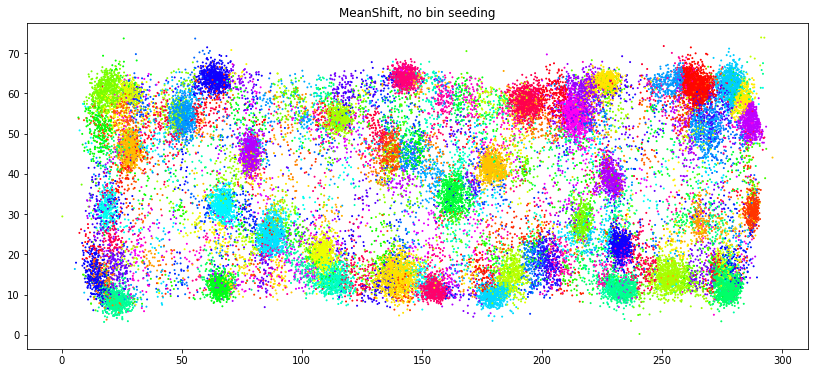

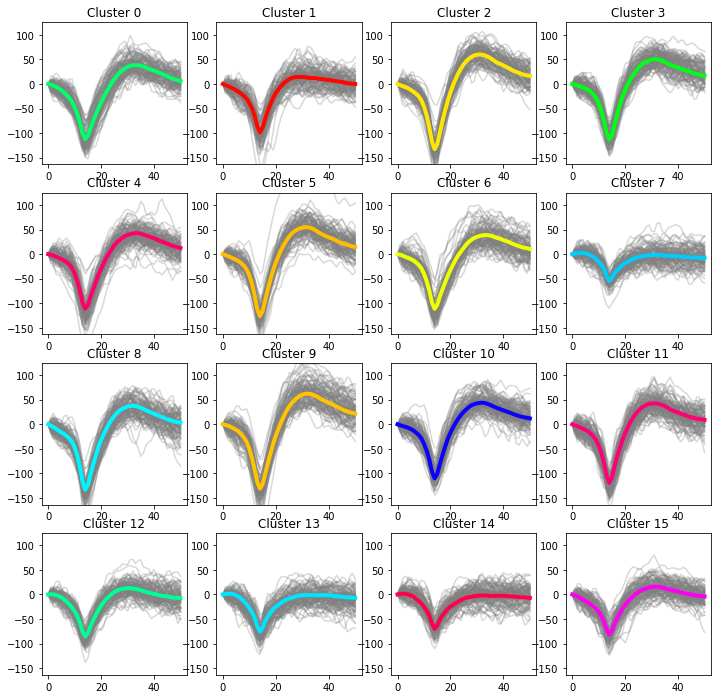

In [26]:
get_cluster(0.25)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   33.5s remaining:  1.7min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   36.5s remaining:    7.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   37.8s finished


Number of estimated units: 3778


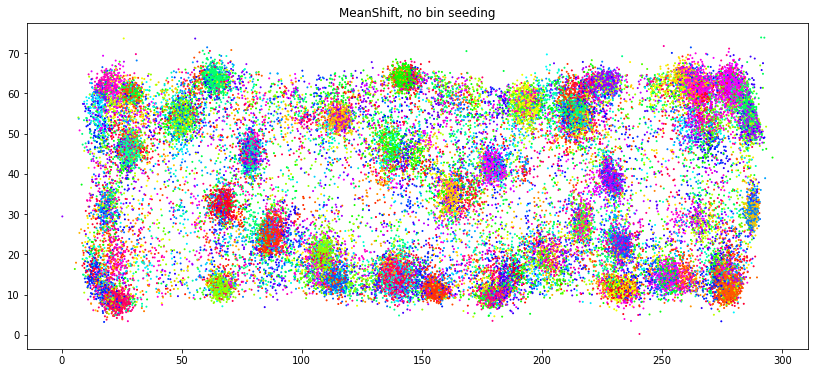

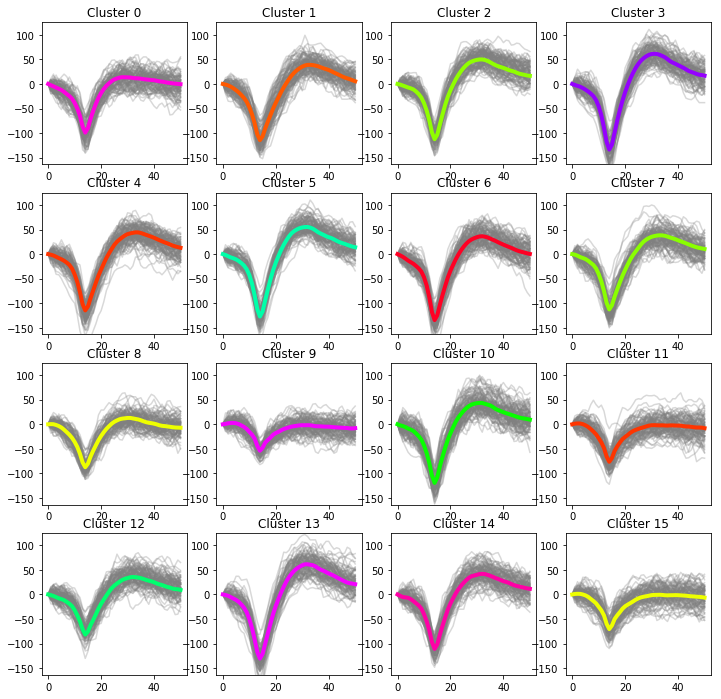

In [27]:
get_cluster(0.5)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   14.5s remaining:   43.4s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   15.1s remaining:    3.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   15.7s finished


Number of estimated units: 10159


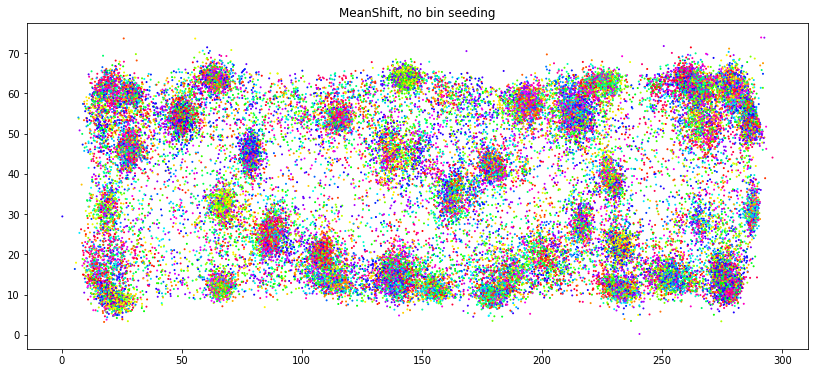

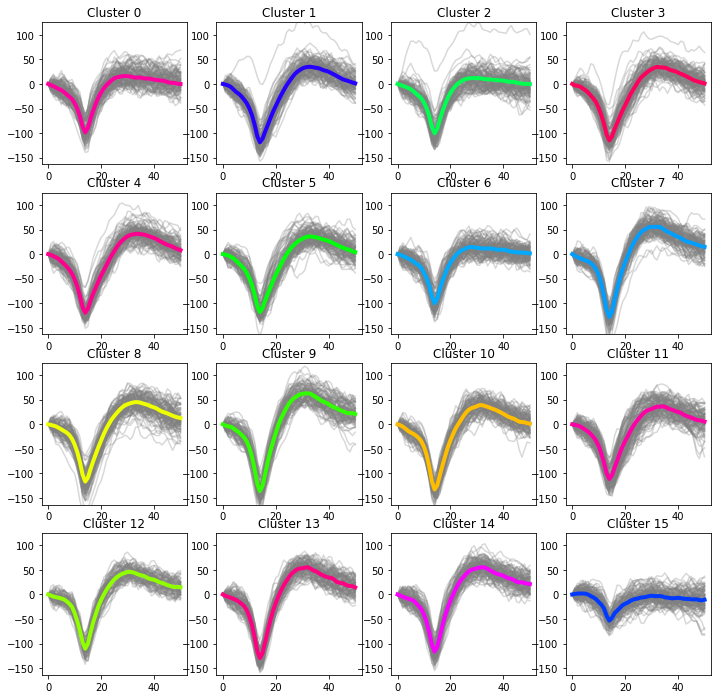

In [28]:
get_cluster(1)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    6.1s remaining:   18.2s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    6.5s remaining:    1.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    7.0s finished


Number of estimated units: 20640


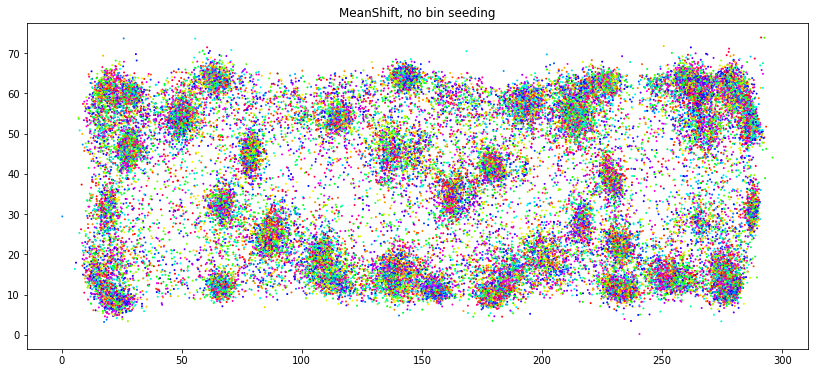

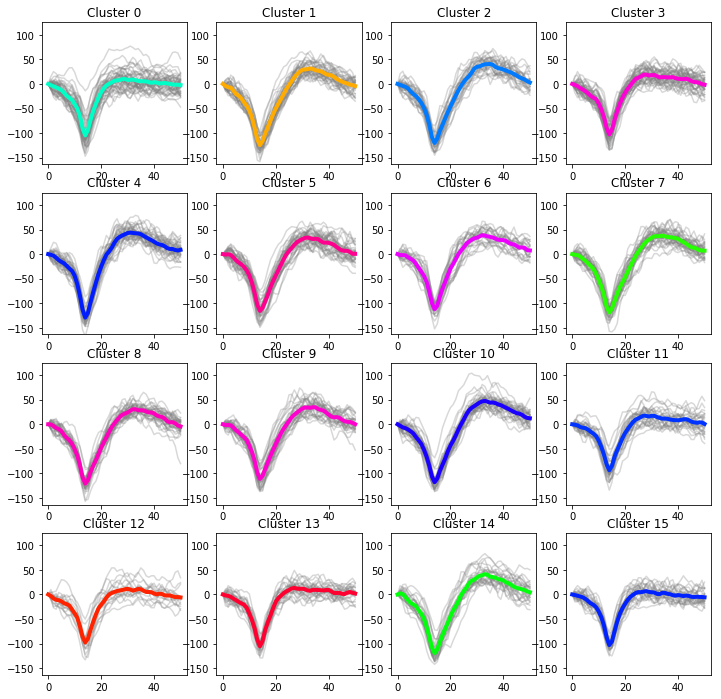

In [29]:
get_cluster(2)

units = range(16)
C.PlotShapes(units)